# LSTM과 GRU 셀

일반적으로 기본 순환층은 긴 시퀀스를 학습하기 어렵다.
시퀀스가 길수록 순환되는 은닉상태에 담긴 정보가 점차 희석되기 때문이다.
따라서 멀리 떨어져 있는 단어 정보를 인식하는 데 어려울 수 있다.

### LSTM 구조

LSTM은 Long Short - Term Memory의 약자이다. 말 그대로 단기 기억을 오래 기억하기 위해 고안되었다. LSTM은 구조가 복잡하다.

먼저 은닉 상태를 만드는 법이다.
은닉 상태는 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만든다. 이때 기본 순환층과는 달리 시그모이드 함수를 사용한다. 또 tanh활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만든다.

LSTM에는 순환되는 상태가 2개이다. 은닉 상태 말고 셀 상태(cell state)라고 부르는 값이 있다. 은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값이다.

LSTM은 마치 작은 셀을 여러 개 포함하고 있는 큰 셀 같다. 중요한 것은 입력과 은닉 상태에 곱해지는 가중치 w_o와 w_f 가 다르다는 것이다.

여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는 데 기여한다.

이전과 마찬가지로 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음, 하나는 시그모이드 함수를 통과시키고 다른 하나는 tanh 함수를 통과시킨다. 그다음 두 결과를 곱한 후 이전 셀 상태와 더한다. 이 결과가 최종적인 다음 셀 상태가 된다.



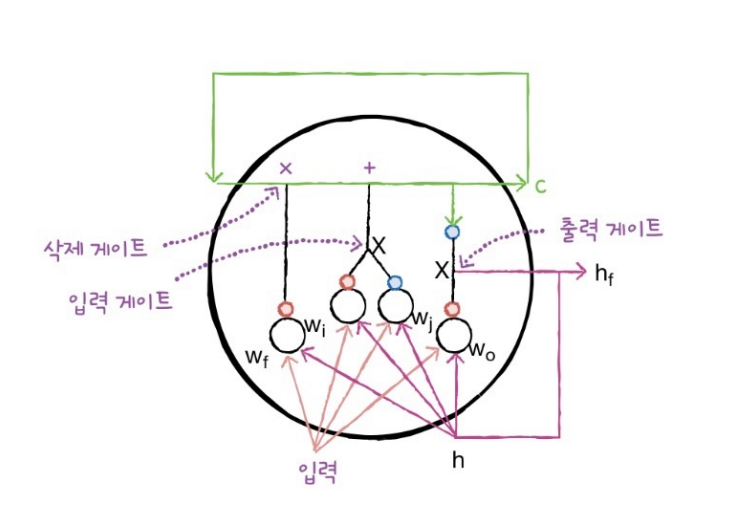

위 그림처럼 세 군데의 곱셈을 왼쪽부터 차례대로 삭제 게이트, 입력 게이트, 출력 게이트라고 부른다.

삭제 게이트는 셀 상태에 있는 정보를 제거하는 역할을 하고 입력 게이트는 새로운 정보를 셀 상태에 추가한다. 출력 게이트를 통해서 이 셀 상태가 다음 은닉 상태로 출력된다.

LSTM 클래스를 사용해 LSTM 순환 신경망을 만들어보자.

### LSTM 신경망 훈련하기

먼저 data spliting

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words = 500
)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size = 0.2, random_state = 42
)

17464789/17464789 [==============================] - 1s 0us/step


그다음 케라스의 pad_sequences() 함수로 각 샘플의 길이를 100에 맞추고 부족할 때는 패딩을 추가한다.

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen =100)
val_seq = pad_sequences(val_input, maxlen = 100)

이제 LSTM 셀을 사용한 순환층을 만들어 보자

In [6]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length = 100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1,activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8809 (34.41 KB)
Trainable params: 8809 (34.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5',
                                                save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data = (val_seq, val_target),
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 44ms/step - loss: 0.6929 - accuracy: 0.5179 - val_loss: 0.6925 - val_accuracy: 0.5490
Epoch 2/100
  3/313 [..............................] - ETA: 11s - loss: 0.6917 - accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 14s 46ms/step - loss: 0.6918 - accuracy: 0.5635 - val_loss: 0.6912 - val_accuracy: 0.5834
Epoch 3/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6899 - accuracy: 0.6075 - val_loss: 0.6884 - val_accuracy: 0.6192
Epoch 4/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6854 - accuracy: 0.6327 - val_loss: 0.6815 - val_accuracy: 0.6454
Epoch 5/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6710 - accuracy: 0.6553 - val_loss: 0.6533 - val_accuracy: 0.6764
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6291 - accuracy: 0.7149 - val_loss: 0.6114 - val_accuracy: 0.7212
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6001 - accuracy: 0.7284 - val_loss: 0.5917 - val_accuracy: 0.7346
Epoch 8/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5802 - accuracy: 0.7421 - val_loss: 0.5743 - val_accuracy: 0.74

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

NameError: name 'history' is not defined

그래프를 보면 기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행한 것으로 보인다. 하지만 경우에 따라서는 과대적합을 더 강하게 제어할 필요가 있다.

### 순환층에 드롭아웃 적용하기

완전 연결 신경망과 합성곱 신경망에서는 Dropout 클래스를 사용해 드롭아웃을 적용했다. 이를 통해 모델이 훈련 세트에 너무 과대적합되는 것을 막는다.
SimpleRNN과 LSTM 클래스 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있다.

dropout 매개변수는 셀의 입력에 드롭아웃을 적용하고 recurrent_dropout은 순환되는 은닉 상태에 드롭아웃을 적용한다. 하지만 기술적인 문제로 인해 recurrent_dropout을 사용하면 GPU를 사용하여 모델을 훈련하지 못한다. 이 때문에 모델의 훈련 속도가 크게 느려진다. 따라서 여기에서는 dropout만 사용하자.

In [ ]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length = 100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights = True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data = (val_seq, val_target),
                     callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 46ms/step - loss: 0.6923 - accuracy: 0.5347 - val_loss: 0.6917 - val_accuracy: 0.5706
Epoch 2/100
  4/313 [..............................] - ETA: 13s - loss: 0.6912 - accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 14s 44ms/step - loss: 0.6906 - accuracy: 0.5841 - val_loss: 0.6896 - val_accuracy: 0.6050
Epoch 3/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6871 - accuracy: 0.6133 - val_loss: 0.6849 - val_accuracy: 0.6274
Epoch 4/100
313/313 [==============================] - 14s 43ms/step - loss: 0.6786 - accuracy: 0.6476 - val_loss: 0.6718 - val_accuracy: 0.6528
Epoch 5/100
313/313 [==============================] - 16s 51ms/step - loss: 0.6475 - accuracy: 0.6759 - val_loss: 0.6157 - val_accuracy: 0.6942
Epoch 6/100
313/313 [==============================] - 14s 43ms/step - loss: 0.5846 - accuracy: 0.7200 - val_loss: 0.5735 - val_accuracy: 0.7234
Epoch 7/100
313/313 [==============================] - 14s 44ms/step - loss: 0.5545 - accuracy: 0.7373 - val_loss: 0.5493 - val_accuracy: 0.7356
Epoch 8/100
313/313 [==============================] - 14s 43ms/step - loss: 0.5334 - accuracy: 0.7508 - val_loss: 0.5288 - val_accuracy: 0.75

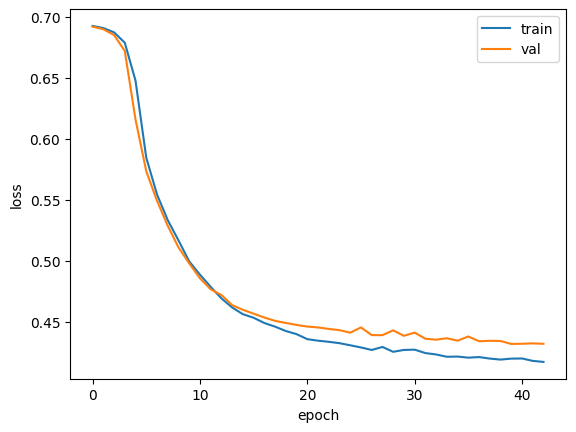

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

LSTM 층에 적용한 드롭아웃이 효과를 발휘한 것 같다. 훈련 손실과 검증 손실 간의 차이가 좁혀진 것을 확인할 수 있다.

밀집층이나 합성곱 층처럼 순환층도 여러 개를 쌓지 않을 이유가 없다.

### 2개의 층을 연결하기

순환층을 연결할 때는 한 가지 주의할 점이 있다. 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요하다. 따라서 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 한다. 오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야 한다.

케라스의 순환층에서 모든 타임스텝의 은닉 샅애를 출력하려면 마짐가을 제외한 다른 모든 순환층에서 return_sequences 매개변수를 True로 지정하면 된다.


In [ ]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9353 (36.54 KB)
Trainable params: 9353 (36.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size = 64,
                     validation_data = (val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 33s 89ms/step - loss: 0.6925 - accuracy: 0.5343 - val_loss: 0.6914 - val_accuracy: 0.5992
Epoch 2/100
  2/313 [..............................] - ETA: 21s - loss: 0.6916 - accuracy: 0.6016

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 26s 82ms/step - loss: 0.6891 - accuracy: 0.6051 - val_loss: 0.6844 - val_accuracy: 0.6534
Epoch 3/100
313/313 [==============================] - 26s 83ms/step - loss: 0.6612 - accuracy: 0.6662 - val_loss: 0.6170 - val_accuracy: 0.6998
Epoch 4/100
313/313 [==============================] - 27s 87ms/step - loss: 0.5902 - accuracy: 0.7089 - val_loss: 0.5653 - val_accuracy: 0.7246
Epoch 5/100
313/313 [==============================] - 26s 82ms/step - loss: 0.5520 - accuracy: 0.7332 - val_loss: 0.5302 - val_accuracy: 0.7474
Epoch 6/100
313/313 [==============================] - 25s 80ms/step - loss: 0.5228 - accuracy: 0.7539 - val_loss: 0.5140 - val_accuracy: 0.7592
Epoch 7/100
313/313 [==============================] - 25s 81ms/step - loss: 0.5054 - accuracy: 0.7640 - val_loss: 0.4956 - val_accuracy: 0.7700
Epoch 8/100
313/313 [==============================] - 25s 80ms/step - loss: 0.4929 - accuracy: 0.7720 - val_loss: 0.4863 - val_accuracy: 0.77

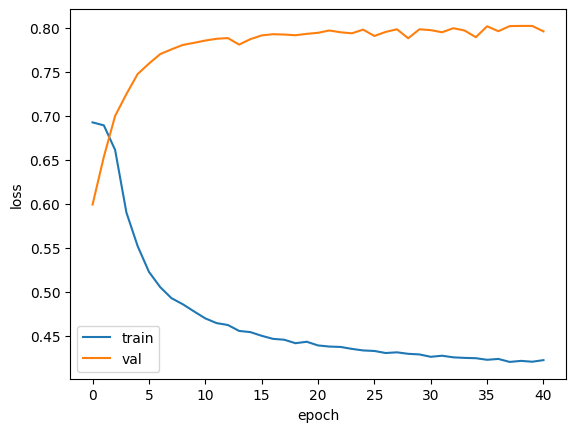

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

이상해...

###GRU 구조

GRU는 Gated Recurrent Unit의 약자이다. 뉴욕 대학교 조경현 교수가 발명한 셀로 유명하다. 이 셀은 LSTM을 간호화한 버전으로 생각할 수 있다. LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함하고 있다.

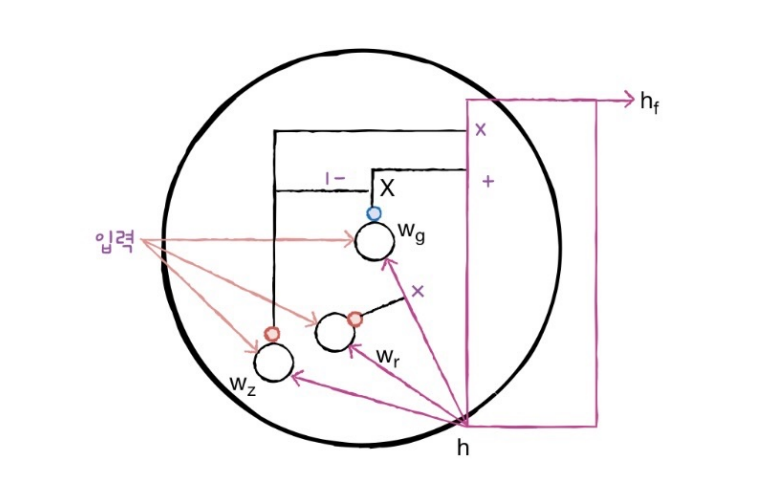

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있다. 2개는 시그모이드 활성화 함수를 사용하고 하나는 tanh 활성화 함수를 사용한다. 여기에서도 은닉 상태와 곱해지는 가중치를 합쳐서 나타냈다.

GRU 셀은 LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM 못지않은 좋은 성능을 내는 것으로 알려져 있다.

### GRU 신경망 훈련하기

In [9]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [10]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8633 (33.72 KB)
Trainable params: 8633 (33.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy',
               metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size = 64,
                    validation_data = (val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 16s 45ms/step - loss: 0.6926 - accuracy: 0.5250 - val_loss: 0.6924 - val_accuracy: 0.5350
Epoch 2/100
  3/313 [..............................] - ETA: 10s - loss: 0.6929 - accuracy: 0.4948

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 13s 43ms/step - loss: 0.6914 - accuracy: 0.5530 - val_loss: 0.6909 - val_accuracy: 0.5534
Epoch 3/100
313/313 [==============================] - 14s 44ms/step - loss: 0.6894 - accuracy: 0.5755 - val_loss: 0.6887 - val_accuracy: 0.5640
Epoch 4/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6862 - accuracy: 0.5884 - val_loss: 0.6849 - val_accuracy: 0.5870
Epoch 5/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6812 - accuracy: 0.6029 - val_loss: 0.6790 - val_accuracy: 0.5986
Epoch 6/100
313/313 [==============================] - 15s 47ms/step - loss: 0.6732 - accuracy: 0.6210 - val_loss: 0.6698 - val_accuracy: 0.6160
Epoch 7/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6603 - accuracy: 0.6431 - val_loss: 0.6541 - val_accuracy: 0.6394
Epoch 8/100
313/313 [==============================] - 13s 42ms/step - loss: 0.6371 - accuracy: 0.6657 - val_loss: 0.6238 - val_accuracy: 0.67

손실을 그래프로 그려보자.

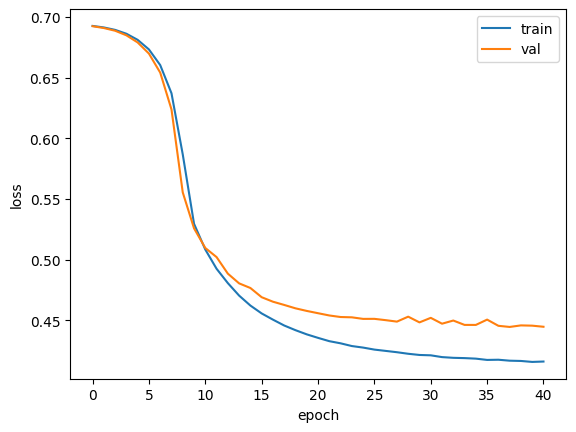

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

드롭아웃을 사용하지 않았기 대문에 이전보다 훈련 손실과 검증 손실 사이에 차이가 있지만 훈련 과정이 잘 수렴되고 있는 것을 확인할 수 있다.